## Overview
Train a network to play snake. This demo is motivated by [this video](https://www.youtube.com/watch?v=L8ypSXwyBds)

## High-Level Theory

This demo is fundamental a reinforcement learning implementation. The network acts as an agent within the constructed game environment. The agent learns by optimizing a *cumulative* reward function. The specific approach is called ***Deep Q Learning*** which is an extension of reinforcement learning that incorporates deep neural networks into RL to predict actions.

Basic ingredients:
- **State** (environment)
    - The agent (model) needs to be able to take information about its environment as input
- **Action**
    - The agent needs to be able to take actions (as output or as a decision function of output)
- **Reward**
    - The agent needs an error function that incorporates information about desired actions

Basic reward:
- Eat food: +10
- Game over: -10
- Else: 0  (neutral actions)

Action Set:
-  `[1, 0, 0]` -- straight
-  `[0, 1, 0]` -- right turn
-  `[0, 0, 1]` -- left turn

State:
- What information does the agent have? The video gives the following:
    - danger straight, danger right, danger left
        - This only accounts for obstacles that are within 1 move of the snake (the agent)
    - direction left, direction right, direction up, direction down
        - This is the information about the snake's *current* orientation
        - E.g. if the snake is heading right, then this vector would be `[0, 1, 0, 0]
    - food left, food right, food up, food down
        - This is relative to the snake's current position but is unrestricted by distance.
        - E.g. if the food is 10 moves down and 5 moves left then this vector would be `[1, 0, 0, 1]`
            - If the snake closed the distance to 2 moves down and 3 moves left then the vector would still be `[1, 0, 0, 1]`

The state will be given as an input to the model. This proposed state has 11 elements, so the expected input will be a vector in 11 dimensions. The output of the model will be the action.

### Deep Q Learning (in brief)
"Q" stands for *Quality* of Action

Basic steps:
0. Initialize Q value
1. Choose action (feed through model)
2. Perform action
3. Evaluate reward
4. Update Q value
    - And backpropogate through model

So the notion of the "Q" value seems connected to the error function used for training. The specific loss function used in this video is the ***Bellman Equation***:
$$Q_\text{New}(s, a) = Q(s, a) + \alpha\bigg[ R(s, a) + \gamma \max Q'(s', a') - Q(s, a)  \bigg]$$
Where $Q(s,a)$ is the $Q$ value as a function of the state $s$ and action $a$, the learning rate is $\alpha$, the reward is a function of the state and action $R(s, a)$, $\gamma$ is a hyperparameter called the *discount rate*, and $Q'(s', a')$ is the expected future reward function of the future state $s'$ and action set $a'$.

The Bellman equation specifies the new *updated* $Q$ value as a function of the current $Q$ value $Q(s, a)$, the reward $R(s, a)$, and the discounted expected future $Q$ value $\gamma Q'(s', a')$

In the video, this is simplified for implementation as:
$$
Q = \text{model.predict}(s_{t-1}) \\
Q_\text{new} = R(s_{t-1}) + \gamma \max(Q(s_t))
$$

Then, the loss function is specified as:
$$loss = (Q_\text{new} - Q)^2$$
Which is analagous to the squared error loss

## The Game

I don't really care much about programming the game, so this is cribbed directly from the video

### Human-Playable Version

In [2]:
import pygame
import random
from enum import Enum
from collections import namedtuple

pygame.init()
font = pygame.font.SysFont('arial', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4
    
Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 20
SPEED = 20

class SnakeGame:
    
    def __init__(self, w=640, h=480):
        self.w = w
        self.h = h
        # init display
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Snake')
        self.clock = pygame.time.Clock()
        
        # init game state
        self.direction = Direction.RIGHT
        
        self.head = Point(self.w/2, self.h/2)
        self.snake = [self.head, 
                      Point(self.head.x-BLOCK_SIZE, self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]
        
        self.score = 0
        self.food = None
        self._place_food()
        
    def _place_food(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE 
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()
        
    def play_step(self):
        # 1. collect user input
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    self.direction = Direction.LEFT
                elif event.key == pygame.K_RIGHT:
                    self.direction = Direction.RIGHT
                elif event.key == pygame.K_UP:
                    self.direction = Direction.UP
                elif event.key == pygame.K_DOWN:
                    self.direction = Direction.DOWN
        
        # 2. move
        self._move(self.direction) # update the head
        self.snake.insert(0, self.head)
        
        # 3. check if game over
        game_over = False
        if self._is_collision():
            game_over = True
            return game_over, self.score
            
        # 4. place new food or just move
        if self.head == self.food:
            self.score += 1
            self._place_food()
        else:
            self.snake.pop()
        
        # 5. update ui and clock
        self._update_ui()
        self.clock.tick(SPEED)
        # 6. return game over and score
        return game_over, self.score
    
    def _is_collision(self):
        # hits boundary
        if self.head.x > self.w - BLOCK_SIZE or self.head.x < 0 or self.head.y > self.h - BLOCK_SIZE or self.head.y < 0:
            return True
        # hits itself
        if self.head in self.snake[1:]:
            return True
        
        return False
        
    def _update_ui(self):
        self.display.fill(BLACK)
        
        for pt in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(pt.x+4, pt.y+4, 12, 12))
            
        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))
        
        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()
        
    def _move(self, direction):
        x = self.head.x
        y = self.head.y
        if direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif direction == Direction.UP:
            y -= BLOCK_SIZE
            
        self.head = Point(x, y)

### Test-Run

In [3]:
pygame.init()
game = SnakeGame()
pygame.time.delay(1000)

# try:  
# game loop
while True:
    game_over, score = game.play_step()
    pygame.time.delay(100)
    
    if game_over == True:
        break
    
print('Final Score', score)
    
pygame.quit()

Final Score 7


### AI Version

The AI version implements the following adaptations from the human-playable version:
- Remove human inputs in the `play_step` method
    - i.e. the key entries for updating `self.direction`
    - Relatedly, the argument `action` is added to the `play_step` and `_move` methods to accept an action vector as input instead of key entries
- Add a `frame_iteration` counter
    - This counter is similar to the number of training (or playing) steps taken but is not actually the steps
        - It is the frames passed by the game not the number of forward passes through the network / decisions taken by the agent
        - So, there is a positive relationship between the two, but it is not literally the number of training steps and if for some reason the network is running slowly, then many frames may elapse per forward pass
    - Because there is no longer a default `self.direction` taken in the `play_step` method, the snake will not move without being given an action vector
        - The agent should always provide an action vector, but in case it is buggy (or in case it learns to never take negative actions, leading to stalemates when all of its actions lead to a negative reward) we add the condition in line `78` to end the game if `self.frame_iteration > 100*len(self.snake)`
            - This logic gives more time when the 
- Add rewards
    - Reward values are added for each outcome of an action
        - +10 for eating, -10 for game over, 0 (neutral) otherwise
    - Reward is added to the `return` statement from `play_step`
- Add `pt` argument to `is_collision`
    - Not really sure why tbh

In [4]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

pygame.init()
font = pygame.font.SysFont('arial', 25)

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 20
SPEED = 40

class SnakeGameAI:

    def __init__(self, w=640, h=480):
        self.w = w
        self.h = h
        # init display
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Snake')
        self.clock = pygame.time.Clock()
        self.reset()


    def reset(self):
        # init game state
        self.direction = Direction.RIGHT

        self.head = Point(self.w/2, self.h/2)
        self.snake = [self.head,
                      Point(self.head.x-BLOCK_SIZE, self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0


    def _place_food(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()


    def play_step(self, action):
        self.frame_iteration += 1
        # 1. collect user input
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        
        # 2. move
        self._move(action) # update the head
        self.snake.insert(0, self.head)
        
        # 3. check if game over
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100*len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score

        # 4. place new food or just move
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()
        
        # 5. update ui and clock
        self._update_ui()
        self.clock.tick(SPEED)
        # 6. return game over and score
        return reward, game_over, self.score


    def is_collision(self, pt=None):
        if pt is None:
            pt = self.head
        # hits boundary
        if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
            return True
        # hits itself
        if pt in self.snake[1:]:
            return True

        return False


    def _update_ui(self):
        self.display.fill(BLACK)

        for pt in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(pt.x+4, pt.y+4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()


    def _move(self, action):
        # [straight, right, left]

        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx] # no change
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx] # right turn r -> d -> l -> u
        else: # [0, 0, 1]
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx] # left turn r -> u -> l -> d

        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

## Training & Agent

I think it's more clear if we address the training first.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

This training process is ambiguous without further context.

Initially, the agent's actions will be largely random. Taking random actions is ***"Exploration"*** in the RL parlance. As it takes actions, it will update its state. Training is then done over the memory of states. Here's the rough outline:
1. Get current state
2. Take an action
3. Evaluate new state along with reward of action
4. Add new state and reward into working memory (simply an iterable)
Then, we have *two* varieties of training. One is short-term, the other is long-term:
5. Short-Term training (in this demo, this occurs during play at each action step)
    - Run a training loop over the previous state, the new state, the action, and the received reward
        - So, the `state` passed to `train_step` is the previous state before an action was taken
        - The `new_state` is the state after an action was taken
        - The `action` is the action that was actually taken
        - And the `reward` is the reward received for the action
    - So, the expression for `Q_new` is the reward received *plus* the discounted model expected reward for the `new_state` (i.e. the state attained after taking the action)
        - In truth, this is retrospective because we've already reached the `new_state`; however, the `Q_new` value must be treated as a prospective value
        - The loss function is then the MSE loss between `Q_new` and the model's prediction (i.e. the prediction for the original `state`)
            - Thus, the model is trained to predict `Q_new` values given each `state`
6. Long-Term training
    - Once the game has ended, the model trains over all states (or more accurately, all (`state`, `new_state`) pairs) observed over the course of the game

One more important detail:\
After each game, the model is **saved**, only if its attained `score` is greater than the previously saved model's `score`.
This ensures that the model will become more performant each run.

Now we can specify the Agent:

In [9]:
import torch
import random
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
from IPython import display

plt.ion()

def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)
    

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # Food location 
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        #for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)

<Figure size 640x480 with 0 Axes>

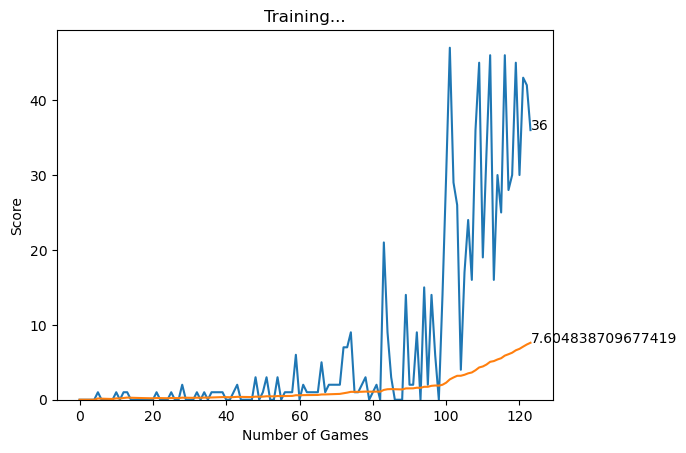

error: display Surface quit

: 

In [10]:
pygame.init()
train()

V cool v cool

## Modifications

Modifications that may be worth exploring:
- Would behavior change if we gave the model more information about the location of food?
    - Such as encoding number of blocks in the food vector rather than binary indicators
- Could we improve the inter-game training by doing something other than simply saving the top-scoring model?
    - Maybe a test case for exploring genetic algorithms
- Could we separate the information about the types of obstacles?
    - Like have a `walls` vector and a `body` vector
    - The body vector could posibly encode information about how many blocks away the body is in each direction, which may be able to prevent the agent from getting stuck in so many recursive knots...
- Could we explore adding a context length of states as input; i.e. include multiple states as input so that the agent can learn based off of recent memory of prior moves?
    - Or maybe just past actions... The input could look like a state vector extended by the past $n$ action vectors...

If we watch the training for a long time, we may observe that the frequency of these recursive knots decreases substantially after game 100 or so. However, they do still occur. Perhaps because the agent doesn't know what to di in unseen configurations of states that can lead to knots. With enough time, they may disappear entirely...

### Adding Past Actions as Input to NN

I saved the .py files from the [repo](https://github.com/patrickloeber/snake-ai-pytorch) associated with the video so that I can make modifcations and test out changes more easily.\
Here, I attempt to include the past 3 actions as input to model during training.

<Figure size 640x480 with 0 Axes>

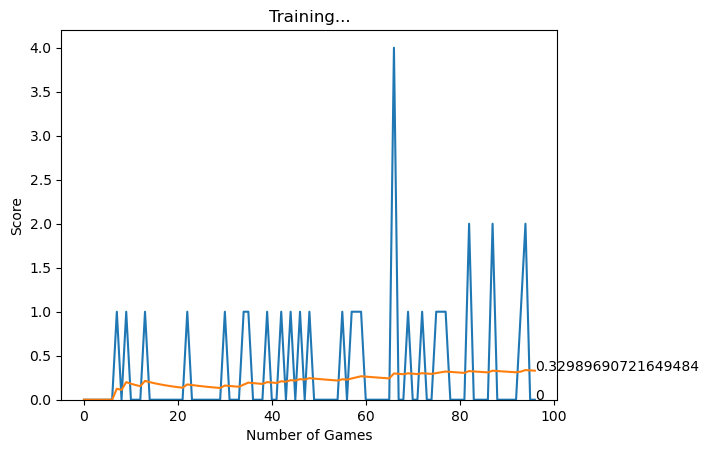

NameError: name 'quit' is not defined

In [1]:
import pygame
import game, agent, model

pygame.init()
agent.train()

So, if anything, this modification seems to degrade performance. Why?\
The snake avoided getting into as many recursive knots, but still wound up in some. Overall, its behavior is consistently more erratic. Why is it struggling to learn when it includes a memory of past moves....?

Here, I attempt training with only the most recent move added to the state input.

<Figure size 640x480 with 0 Axes>

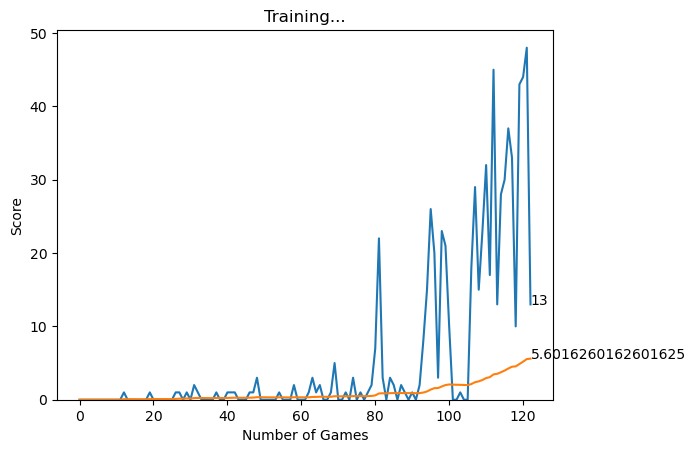

error: display Surface quit

In [1]:
import pygame
import game, agent, model

pygame.init()
agent.train()

So, this also hasn't worked great, but it has lead to some really interesting behavior. Most notably, the agent seems to get hooked on circling the game window endlessly. It also avoided recursive knots almost completely until about game 80, afterwhich it entered them consistently for the next 20 games or so...

By about game 100 this buggy behavior abated, but it maintained a preference for circling around the border, only deviating from the edges to get food. Some other odd loops have occurred occasionally though.